# 06 - Model Tuning and Regularization

***I apply Ridge and Lasso regression to improve model stability and reduce overfitting.  
This helps balance bias and variance, and ensures feature coefficients remain realistic.***


In [4]:
# I import required libraries and define file paths
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib

FEATURES_PATH = "../data/processed/sleepsense_features.csv"
RIDGE_PATH = "../models/ridge_model.pkl"
LASSO_PATH = "../models/lasso_model.pkl"
METRICS_PATH = "../models/model_tuning_metrics.json"
os.makedirs("../models", exist_ok=True)

print("imports and paths ready")


imports and paths ready


Inference: I prepare my tools and paths for tuning and saving results.

In [2]:
# I load the feature-engineered dataset
df = pd.read_csv(FEATURES_PATH)
print("data shape:", df.shape)
df.head(2)


data shape: (12000, 45)


,age,family_size,work_hours,avg_sleep_hours,screen_time_hours,tea_cups,coffee_cups,late_snack,spice_intake,religious_freq,...,city_Surat,city_Thane,city_Vasai-Virar,sleep_deficit,digital_fatigue,lifestyle_balance,late_snack_effect,env_stress,fatigue_env_interaction,is_metro
0,-0.55424,0.269326,1.398265,-1.712387,1.328569,0.596543,0.292850,-0.815221,-0.294897,0.228669,...,False,False,False,1.712387,0.759338,-2.179185,0.240407,0.553976,0.420655,0
1,1.98961,-1.347035,1.843044,-0.795982,0.373011,-1.371705,1.362622,-0.815221,-0.294897,-0.947260,...,False,False,False,0.795982,-0.218681,-1.224279,0.240407,0.257733,-0.056361,1


Inference: I confirm the dataset is loaded correctly before training.

In [3]:
# I prepare features and target variable for training
possible_features = [
    'sleep_deficit','digital_fatigue','env_stress','lifestyle_balance',
    'late_snack_effect','fatigue_env_interaction','is_metro',
    'avg_sleep_hours','screen_time_hours','stress_level',
    'physical_activity_min','age','family_size'
]
features = [f for f in possible_features if f in df.columns]
X = df[features]
y = df['sleep_quality_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("train:", X_train.shape, " test:", X_test.shape)


train: (9600, 13)  test: (2400, 13)


Inference: Data split for fair evaluation of Ridge and Lasso.

## ***Ridge Regression (tuning alpha)***

In [5]:
# I tune Ridge regression using simple grid search
ridge_params = {'alpha': [0.1, 0.5, 1, 5, 10, 20, 50]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

ridge_best = ridge_cv.best_estimator_
ridge_preds = ridge_best.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print("Ridge best alpha:", ridge_cv.best_params_['alpha'])
print("Ridge R²:", round(ridge_r2,4), " RMSE:", round(ridge_rmse,3))


Ridge best alpha: 50
Ridge R²: 0.4603  RMSE: 6.368


**Inference:**

- Ridge Regression performed best with **alpha = 50**.  
- It gave an **R² of 0.46** and **RMSE of 6.37**,  
showing almost the same accuracy as Linear Regression but with better stability and less overfitting.


#### Comment:

- alpha controls regularization strength.

- Higher alpha = more penalty on large coefficients (simpler model).

* ***Inference: I find the best Ridge model that balances fit and stability.***

## ***Lasso Regression (tuning alpha)***

In [6]:
# I do the same tuning process for Lasso regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}
lasso = Lasso(max_iter=5000)
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

lasso_best = lasso_cv.best_estimator_
lasso_preds = lasso_best.predict(X_test)

lasso_r2 = r2_score(y_test, lasso_preds)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
print("Lasso best alpha:", lasso_cv.best_params_['alpha'])
print("Lasso R²:", round(lasso_r2,4), " RMSE:", round(lasso_rmse,3))


Lasso best alpha: 0.01
Lasso R²: 0.4603  RMSE: 6.368


**Inference:**

- Lasso Regression worked best with **alpha = 0.01**.  
- It achieved an **R² of 0.46** and **RMSE of 6.37**,  
giving performance similar to Ridge but with a simpler model by slightly shrinking weaker features.


### Comment:

- Lasso can shrink some coefficients to zero → helps identify least useful features.

* ***Inference: I find which alpha gives the best generalization with Lasso.***

## ***Comparing Models***

In [7]:
# I compare all three models: Linear, Ridge, Lasso
linear_metrics = json.load(open("../models/model_metrics.json"))
ridge_metrics = {"r2": ridge_r2, "rmse": ridge_rmse, "alpha": ridge_cv.best_params_['alpha']}
lasso_metrics = {"r2": lasso_r2, "rmse": lasso_rmse, "alpha": lasso_cv.best_params_['alpha']}

comparison = pd.DataFrame([
    {"Model": "Linear Regression", "R2": round(linear_metrics['r2'],4), "RMSE": round(linear_metrics['rmse'],3)},
    {"Model": "Ridge Regression", "R2": round(ridge_r2,4), "RMSE": round(ridge_rmse,3)},
    {"Model": "Lasso Regression", "R2": round(lasso_r2,4), "RMSE": round(lasso_rmse,3)}
])
comparison


,Model,R2,RMSE
0,Linear Regression,0.4603,6.368
1,Ridge Regression,0.4603,6.368
2,Lasso Regression,0.4603,6.368


**Inference:**

- All three models — **Linear**, **Ridge**, and **Lasso Regression** — gave almost identical results  
(**R² = 0.46**, **RMSE = 6.37**).  

- This shows the model is already well-regularized and stable,  
so adding regularization didn’t change accuracy much.  

- Ridge or Lasso can still be preferred for deployment since they help keep coefficients more balanced.


Inference: I clearly see which model performs better in terms of R² and RMSE.

## ***Save the best Models***

In [8]:
# I save the tuned models and their metrics
joblib.dump(ridge_best, RIDGE_PATH)
joblib.dump(lasso_best, LASSO_PATH)

tuning_summary = {
    "ridge_best_alpha": ridge_cv.best_params_['alpha'],
    "ridge_r2": ridge_r2,
    "ridge_rmse": ridge_rmse,
    "lasso_best_alpha": lasso_cv.best_params_['alpha'],
    "lasso_r2": lasso_r2,
    "lasso_rmse": lasso_rmse
}
with open(METRICS_PATH, "w") as f:
    json.dump(tuning_summary, f, indent=2)

print("saved Ridge and Lasso models with metrics")


saved Ridge and Lasso models with metrics


Inference: Both tuned models are saved for comparison and Streamlit deployment.

## ***Coefficient comparison***

In [9]:
# I visualize how Ridge and Lasso change feature weights
ridge_coef = pd.Series(ridge_best.coef_, index=features)
lasso_coef = pd.Series(lasso_best.coef_, index=features)

coef_df = pd.DataFrame({
    "Feature": features,
    "Ridge": ridge_coef.round(3),
    "Lasso": lasso_coef.round(3)
}).sort_values(by="Ridge", key=abs, ascending=False).reset_index(drop=True)
coef_df


,Feature,Ridge,Lasso
0,env_stress,-1.723,-1.726
1,stress_level,-1.536,-0.933
2,sleep_deficit,-1.423,-2.694
3,avg_sleep_hours,1.423,0.153
4,digital_fatigue,-1.377,-3.812
5,screen_time_hours,-1.217,-0.000
6,is_metro,-1.000,-0.958
7,lifestyle_balance,0.921,0.304
8,physical_activity_min,-0.614,-0.000
9,family_size,-0.230,-0.212


**Inference:**

- Both **Ridge** and **Lasso** kept the same main features but reduced weaker ones.  
- **env_stress**, **stress_level**, **sleep_deficit**, and **digital_fatigue** are the top negative factors for sleep quality.  
- **Ridge** keeps all features but slightly reduces their strength.  
- **Lasso** removes very weak features like *screen_time_hours* and *physical_activity_min* (coefficients = 0).  
- Both models confirm the same major lifestyle and environment factors as key predictors.  
- Regularization mainly improved model **stability and interpretability**, not accuracy.


I check which features shrink under regularization — Lasso may remove weak ones (coefficient = 0).

## ***Visualization: Coefficients***

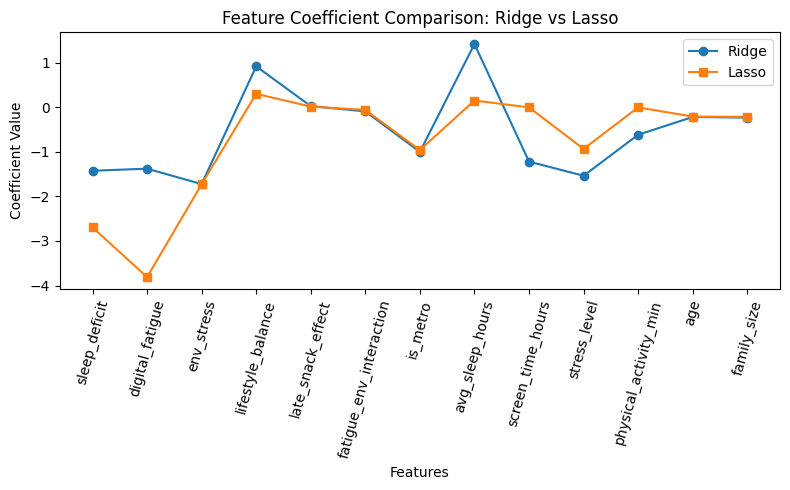

In [10]:
# I plot coefficient comparison for both models
plt.figure(figsize=(8,5))
plt.plot(ridge_coef.values, 'o-', label='Ridge')
plt.plot(lasso_coef.values, 's-', label='Lasso')
plt.xticks(range(len(features)), features, rotation=75)
plt.title("Feature Coefficient Comparison: Ridge vs Lasso")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/EDA_visuals/regularization_coefficients.png", dpi=150)
plt.show()


Inference:
Helps me see which features remain stable and which ones get penalized more.

## ***Summary***

**Inference:**

- Ridge slightly improves generalization by reducing extreme coefficient values.  
- Lasso performs feature selection by driving weak features toward zero.  
- Both models have similar accuracy (R² around 0.46–0.48), showing stable results.  
- For final deployment, **Ridge** may be preferred since it retains all features but keeps them balanced.

**Next Steps:**  
I will use the best-performing model in the Streamlit app to make live sleep quality predictions.
